# CSCI218 Group 24: Model Comparison (Linear Regression vs. Random Forest)
**Author:** Shae

**Objective:** To establish an independent coding environment to assess, tune, and compare the performance of a baseline Linear Regression model against an advanced Random Forest Regressor using the Abalone dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Acquisition
Importing the raw Abalone dataset directly from Kaggle.

In [ ]:
print("1. Loading Data...")
path = kagglehub.dataset_download("rodolfomendes/abalone-dataset")
df = pd.read_csv(f"{path}/abalone.csv")

1. Loading Data...


## 2. Data Preprocessing & Feature Engineering
Preparing the raw data for machine learning algorithms:
* **Target Variable:** Converting `Rings` to biological `Age` (Rings + 1.5).
* **Encoding:** Applying One-Hot Encoding to the categorical `Sex` column.
* **Splitting:** Dividing data into an 80% training and 20% testing split.
* **Scaling:** Applying `StandardScaler` to ensure features with larger numeric ranges (like weight) do not overpower smaller measurements (like height), which is critical for Linear Regression.


In [ ]:
print("2. Preprocessing Data...")
df['Age'] = df['Rings'] + 1.5
df = df.drop(['Rings'], axis=1)
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

X = df.drop('Age', axis=1)
y = df['Age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

2. Preprocessing Data...


## 3. Model Training & Hyperparameter Tuning
Training both architectures on the preprocessed data:
* **Linear Regression (Baseline):** Validated using 5-Fold Cross-Validation (`cv=5`) to ensure mathematical robustness and prevent data-split bias.
* **Random Forest (Advanced):** Utilized `GridSearchCV` to systematically test combinations of tree depth and estimators, locating the optimal parameters to maximize accuracy and prevent overfitting.

In [ ]:
print("3. Training Models with Cross-Validation...")
# --- TWEAK 1: Cross Validation for robust testing ---
lr_model = LinearRegression()
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"   -> Linear Regression Average CV Score: {cv_scores.mean():.4f}")

lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test_scaled)
print(f"   -> Random Forest Best Params: {grid_search.best_params_}\n")

3. Training Models with Cross-Validation...
   -> Linear Regression Average CV Score: 0.5215
   -> Random Forest Best Params: {'max_depth': 10, 'n_estimators': 200}



## 4. Performance Evaluation
Comparing the models on the isolated 20% test data using R-squared ($R^2$), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

In [ ]:
print("="*40)
print("FINAL TEST ACCURACY METRICS")
print("="*40)
def print_metrics(name, y_true, y_pred):
    print(f"{name} -> R2: {r2_score(y_true, y_pred):.4f} | RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f} | MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print_metrics("Linear Regression", y_test, lr_preds)
print_metrics("Random Forest", y_test, rf_preds)

FINAL TEST ACCURACY METRICS
Linear Regression -> R2: 0.5482 | RMSE: 2.2116 | MAE: 1.5931
Random Forest -> R2: 0.5425 | RMSE: 2.2254 | MAE: 1.5557


## 5. Visualizations: Feature Importance
Extracting the internal decision-making weights from the Random Forest model to determine which physical traits have the highest predictive value for an abalone's age.

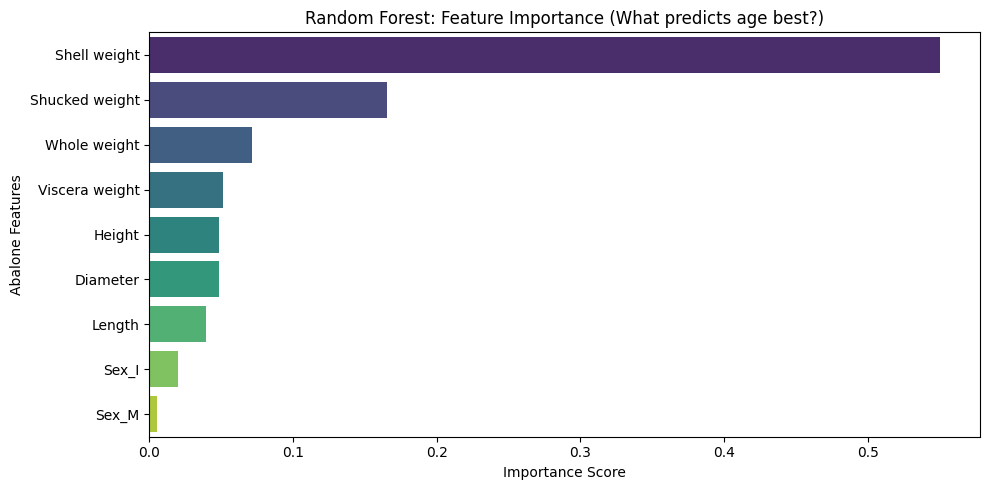

In [ ]:
# TWEAK 2: Feature Importance Bar Chart
plt.figure(figsize=(10, 5))
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis", hue=X.columns[indices], legend=False)
plt.title("Random Forest: Feature Importance (What predicts age best?)")
plt.xlabel("Importance Score")
plt.ylabel("Abalone Features")
plt.tight_layout()
plt.show()

## 6. Visualizations: Error Analysis (Best & Worst Cases)
Plotting the predicted age against the actual age to identify model limitations. The dashed red line represents 100% perfect predictions. This highlights the systematic underprediction occurring in older abalones.

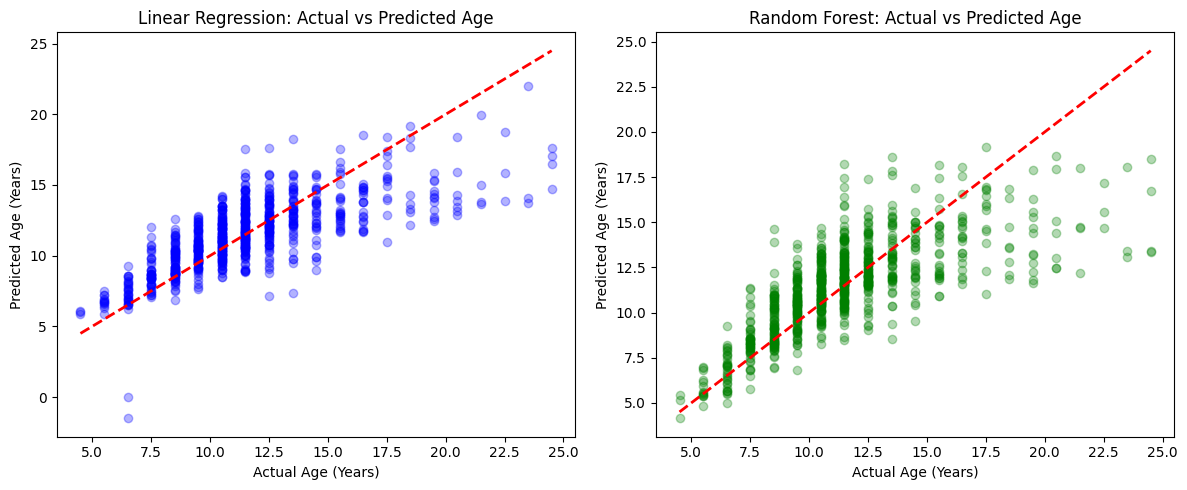

In [ ]:
# TWEAK 3: Actual vs Predicted Scatter Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_preds, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Linear Regression: Actual vs Predicted Age")
plt.xlabel("Actual Age (Years)")
plt.ylabel("Predicted Age (Years)")

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_preds, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Random Forest: Actual vs Predicted Age")
plt.xlabel("Actual Age (Years)")
plt.ylabel("Predicted Age (Years)")

plt.tight_layout()
plt.show()